# **ENVS615**. Analysis of Human Dynamics:<br> The *Geodemographics* of *British Politics*.

Student # 201442927. [Data Analytics & Society MSc/PhD](https://datacdt.org/). [University of Liverpool](https://www.liverpool.ac.uk/). 

## 0. Introduction

### 0.1 Our Task: Data Science using Python

In [18]:
print('Hello World') # start using python (https://www.python.org/)

Hello World


Fifty years after Tukey (1962) declared that data analysis should not be considered merely an application of mathematical statistics, but rather a true scientific domain in its own right, talk of 'data science' has suddenly become ubiquitous (Donoho, 2017). In a much-repeated headline, the Harvard Business Review called it 'the sexiest job of the 21st century' (Davenport and Patil, 2012). Many observe that we are in the midst of a 'data revolution' (Kitchin, 2014).

For this assignment we will be using Python (Van Rossum and Drake, 1995), which is now acknowledged as a mature scientific computational ecosystem (Walt 2019), thanks in no small measure to the work of Oliphant (2006) on [NumPy](https://numpy.org/), and McKinney (2010) on [*pandas*](https://pandas.pydata.org/).

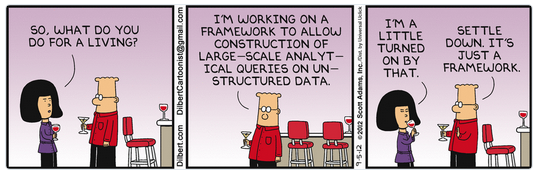

In [19]:
from IPython.display import Image, display, HTML # display images in Jupyter Notebook
# Because cartoons are 'a uniquely effective visual medium for orienting social issues " (Abraham 2009)
import os.path # help python navigate file system regardless of operating system (https://docs.python.org/3/library/os.path.html)

Image(os.path.join('images','data.png')) 

In [20]:
import numpy as np # scientific numerical computing (https://numpy.org/)

import pandas as pd    # fast and efficient data manipulation (https://pandas.pydata.org/)

import matplotlib.pyplot as plt # visualization (https://matplotlib.org/)
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import seaborn as sns # more visualization (https://seaborn.pydata.org/)

import geopandas as gpd # geospatial extension for pandas (https://geopandas.org/)
import geoplot as gplt # geospatial extension for matplotlib (https://residentmario.github.io/geoplot/index.html)
import geoplot.crs as gcrs # for different map projections (https://residentmario.github.io/geoplot/user_guide/Working_with_Projections.html)

import requests # pythonic HTTP library (https://pypi.org/project/requests/)
import io # tools for working with raw file streams (https://docs.python.org/3/library/io.html)
import zipfile # download zip file
# https://stackoverflow.com/questions/44575251/reading-multiple-files-contained-in-a-zip-file-with-pandas
# https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url

import warnings # https://docs.python.org/3/library/warnings.html
warnings.filterwarnings("ignore") # silence warning for final runthrough before exporting as HTML

### 0.2 My Focus: Geodemographics

This course is part of an [integrated M.Sc. and Ph.D](https://datacdt.org/overview/), for which my thesis centers on the field of *geodemographics* (for a thorough account, see Webber and Burrows, 2018; or Harris et al, 2005). Geodemographics is defined variously depending on whether the writer is focussing on its front-end application (eg. Sleight, 1997: the 'analysis of people by where they live') or its back-end development. 

In terms of its development, it is a textbook example of unsupervised machine learning, essentially referring to the algorithmic classification of geographical neighbourhoods by means of computational clustering (cf. Spielman and Folch 2015, p.153).

### 0.3 An Apt Example: British Politics

It strikes me that investigating the subject of British parliamentary politics might be the perfect project for a first foray into the world of geodemographic analysis, for three reasons.

First, the British parliamentary system is, one might say, *geodemographic* by its very nature, in that Members of Parliament are not appointed in proportion to the national percentage of the electorate by whom they have been elected, but rather on the basis of the *first past the post* system, in which whoever wins the most votes (however few) in any particular parliamentary constituency, wins the privilege of representing all the members of that constituency. British politics is thus not about which party wins the most votes, but instead the most constituencies -- or technically the most seats in Parliament; since 1948 (Wikipedia, 2019), these have been equivalent, but before that some constituencies had multiple seats.

Second, whereas once *economics* seemed obviously the driving force in politics, in the last decade *geography* seems the greater force. Some examples: the 'Red Wall' of Labour's northern constituencies being penetrated by the Conservatives; Britain voting to leave the European Union; the Scottish National Party coming to dominate the Scottish constituencies); and many commentators have sought demographic explanations for these shifts.

Third, Dominic Cummings, Director of the Vote Leave campaign, and now the Prime Minister's Senior Advisor, is an outspoken advocate of applying data science to the political process (Cummings 2017). Regardless of whether one would like to help (in which case see Cummings 2020) or hinder Cummings' policies, his recent record of electoral success suggests its power.

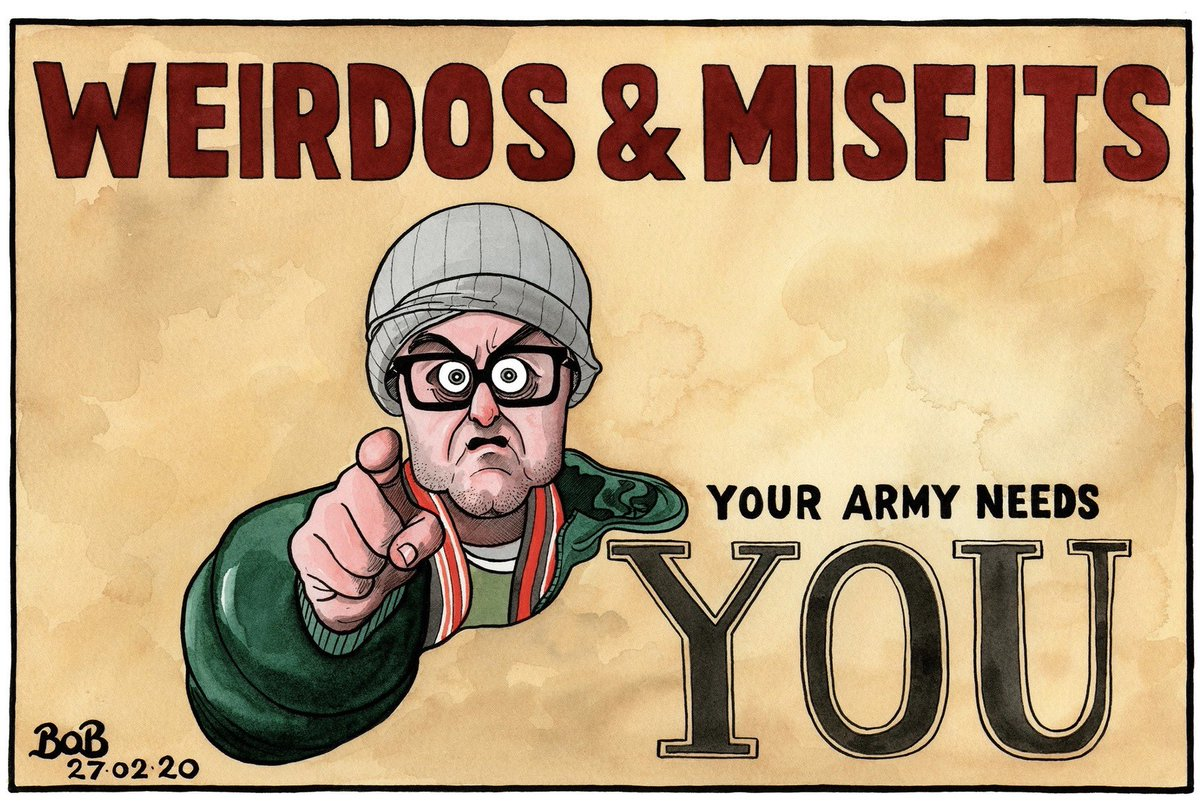

In [21]:
Image(os.path.join('images','misfits.jpg'),width=400,height=200)

## 1. The Data

We will construct our dataset using geographic information, election results, and demographic data from a selection of sources. Most of this will be *open government data*, one of the three main new sources of data highlighted by Arribas-Bel (2014).

In [22]:
dataset = pd.DataFrame()

### 1.0 Contituency Geography

First we can get [shapefiles](https://www.esri.com/library/whitepapers/pdfs/shapefile.pdf) for each parliamentary constituency from [the ONS Geoportal, (2019)](http://geoportal.statistics.gov.uk/datasets/5ce27b980ffb43c39b012c2ebeab92c0_2). This means that if we want, we can easily visualize the data for the constituencies using the familiar geographic shape of the United Kingdom. 

In [23]:
ukmap = gpd.read_file(os.path.join('Westminster_Parliamentary_Constituencies_December_2017_UK_BSC',\
                                'Westminster_Parliamentary_Constituencies_December_2017_UK_BSC.shp'))
pass

The shapefile includes the code and name for each constituency, so we will use these as the foundational starting point for our dataset as we gather constituency data from various sources. It also includes the geometric information to construct a spatial polygon (or in some cases a *multipolygon*) to describe the boundaries of each constituency.

In [24]:
dataset['id'] = ukmap['PCON17CD']
dataset['constituency_name'] = ukmap['PCON17NM']
dataset.shape # (650, 2)
pass

For visualizing political data, it may be more helpful to use a Constituency Hexagon Cartogram (as provided by [Flanagan, 2017](https://www.arcgis.com/home/item.html?id=15baaa6fecd54aa4b7250780b6534682)) that pictures the equivalent political weight of the 650 parliamentary constituencies of the United Kingdom by showing them as equally-sized hexagons.

In [25]:
hexagons = gpd.read_file(os.path.join('GB_Hex_Cartogram_Const','GB_Hex_Cartogram_Const.shp'))
hexagons.head()
# hexagons.plot() # it works
pass

### 1.1 Election Results

Thanks to the [House of Commons Library](https://www.parliament.uk/commons-library), it is easy to find excellent data for the major UK elections stretching back over the last century:

- Full 2019 election results, including vote counts for each party in each constituency, and the winning party in each constituency ([Uberoi et al (2020)](https://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-8749#fullreport)).

- Collated 1918-2017 election results ([Loft et al (2019)](https://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-8647)), with total votes for each constituency given separately for the Conservatives, Labour and the Liberals (now the Liberal Democrats), and jointly for the Scottish and Welsh Nationalists (ie. the SNP and Plaid Cymru) and all Others (these days, this would include both the Green Party and the Brexit Party). However, the data leaves us to work out who won in each constituency, and therefore in each election.

- Estimates for how each constituency voted in the Brexit referendum [(Dempsey ,2017)](https://commonslibrary.parliament.uk/parliament-and-elections/elections-elections/brexit-votes-by-constituency/), updated from [Hanretty's earlier work (2016)](https://medium.com/@chrishanretty/revised-estimates-of-leave-vote-share-in-westminster-constituencies-c4612f06319d).

To understand the implications of the fine details of constituency voting numbers, we will need to compare the counts to see who won each constituency, and then each election, in order that we might perhaps be able to see more general trends.

From the 2010 General Election, each parliamentary constituency has had a consistent ONS reference code that makes cross-referencing data across the 2010, 2015, 2017, and 2019 General Elections and 2016 EU Referendum comparitively straightforward; unfortunately the lack of such a code in previous years makes it more difficult to draw conclusions about individual constituencies from earlier years.

In [26]:
# 2019 election results
url2019 = 'http://researchbriefings.files.parliament.uk/documents/CBP-8749/HoC-2019GE-results-by-constituency.csv'
election2019 = pd.read_csv(url2019)

# election2019.to_csv(os.path.join('data','election2019.csv')) # save file

In [27]:
# 1918-2017 collated general election results
URL_century_of_elections = 'http://researchbriefings.files.parliament.uk/documents/CBP-8647/1918-2017election_results.csv'

century_of_elections = pd.read_csv(URL_century_of_elections, encoding='cp1252')

# save the file
# century_of_elections.to_csv(os.path.join('data','century_of_elections.csv'))

# remove whitespace from column names
century_of_elections.rename(columns=lambda x: x.strip(), inplace=True)
# simplify column labels
century_of_elections.rename(columns=lambda x: x.replace('_votes',''), inplace=True)

In [28]:
shares = ['con_share', 'lib_share', 'lab_share', 'natSW_share', 'oth_share']
century_of_elections[shares] = century_of_elections[shares] *100

parties = ['con','lib','lab','natSW','oth']

# all vote counts should be numeric
for p in parties:
    century_of_elections[p] = pd.to_numeric(century_of_elections[p], errors='coerce')
# as should the electorate figure
century_of_elections['electorate'] = pd.to_numeric(century_of_elections['electorate'], errors='coerce')

# find winning party for each constituency
century_of_elections['winning_party'] = century_of_elections[(p for p in parties)].idxmax(axis=1)

by_election = century_of_elections.groupby('election')

In [29]:
election = {}
elections = list(century_of_elections.election.unique())

In [30]:
for e in elections:
    election[e] = century_of_elections[century_of_elections['election']==e]
    election[e]['total_seats'] = election[e].seats.sum()
    

In [31]:
elections.append('2019')

In [32]:
e2019 = election2019.rename(columns={'ons_id':'constituency_id',
                                'constituency_name' : 'constituency',
                                'region_name' : 'country/region',
                                'ld': 'lib',
                                'valid_votes' : 'turnout',})
e2019 = e2019[['constituency_id', 'constituency', 'country/region', 'con', 'lab', 'lib', 'turnout']]
e2019['natSW'] = election2019['snp'] + election2019['pc']
e2019['oth'] = election2019['brexit'] + election2019['green'] \
            + election2019['dup'] + election2019['sf'] + election2019['sdlp'] \
            + election2019['alliance'] + election2019['other']
e2019['seats'] = 1
e2019['electorate'] = election2019['electorate']
e2019['winning_party'] = e2019[(p for p in parties)].idxmax(axis=1)
for p in parties:
    e2019[f'{p}_share'] = e2019[p]/e2019['turnout'] * 100

In [33]:
e2019['turnout'] = election2019['valid_votes'] / election2019['electorate']

In [34]:
election['2019'] = e2019

In [35]:
summary = {'election':[],
          'con':[],
          'lab':[],
          'lib':[],
          'natSW':[],
          'oth':[],
          'total':[],
          'majority':[],
          'con_votes':[],
           'lab_votes':[],
           'lib_votes':[],
           'natSW_votes':[],
           'oth_votes':[],
          'electorate':[]}

In [36]:
for e in elections:
    summary['election'].append(e)
    total = 0
    announce = {'most_seats':'unknown',
               'num_seats':0}

    summary['electorate'].append(election[e]['electorate'].replace(' ',0).dropna().astype(int).sum())
    
    for p in parties:
        
        data = election[e]
        score = data.loc[data['winning_party']==p,['seats']].sum()
        score = data.loc[data['winning_party']==p,['seats']].sum()
        summary[p].append(score[0])
        summary[p + '_votes'].append(election[e][p].replace(' ',0).dropna().astype(int).sum())
        total += score
        
        
        if score[0] > announce['num_seats']:
            announce['most_seats'] = p
            announce['num_seats'] = score[0]

    if announce['num_seats'] > total[0]/2:
        summary['majority'].append(announce['most_seats'])
    else:
        summary['majority'].append('no majority')        

    summary['total'].append(total[0])  

In [37]:
summarized = pd.DataFrame(summary)

summarized['total_votes'] = summarized[['con_votes','lab_votes','lib_votes','natSW_votes','oth_votes']].sum(axis=1)
summarized['for majority'] = summarized['total']/2
summarized['no_vote'] = (1- summarized['total_votes']/summarized['electorate']) * 100
for p in parties:
    # show percentage of total_votes
    summarized[p+'_share'] = summarized[p+'_votes']/summarized['total_votes'] *100
    # show percentage of total electorate
    summarized[p+'_of_total'] = summarized[p+'_votes']/summarized['electorate'] *100

    
summarized.set_index("election")
summarized.iloc[::-1].set_index("election")

sumT = summarized.iloc[::-1].set_index("election").transpose()
sumT
pass

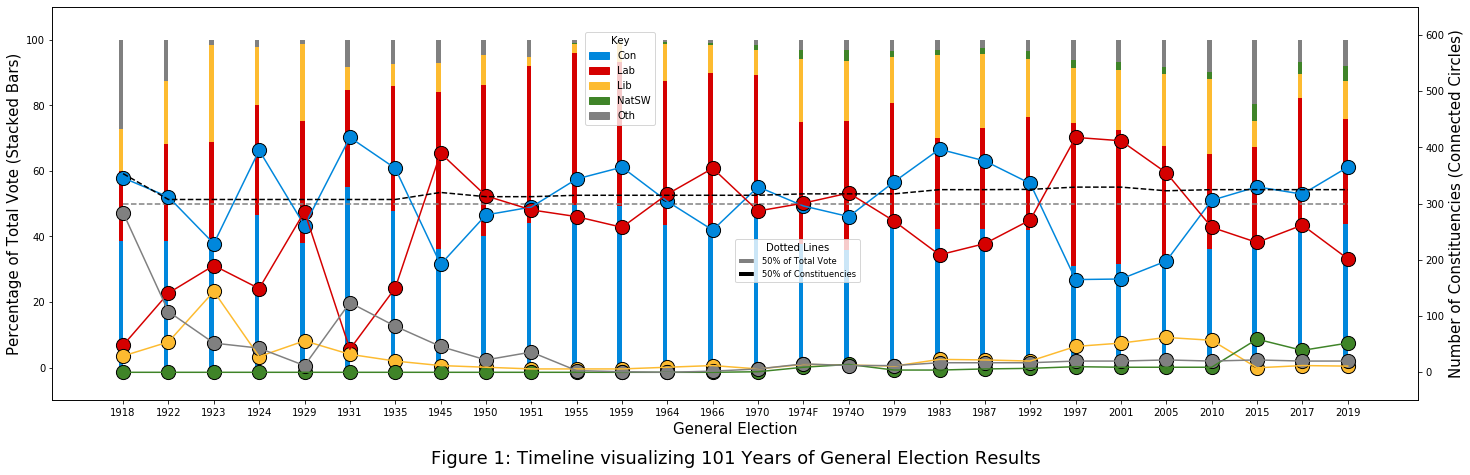

In [38]:
# timeline

colours = {'con':'#0087dc',
         'lab':'#d50000',
         'lib':'#fdbb30',
         'natSW':'#3f8428',
         'oth':'grey'}

parties = ['con','lab','lib','natSW','oth',]

f, ax = plt.subplots(figsize=(20,6))

ax2 = ax.twinx()
ax.set_ylim(-10,110)
ax2.set_ylim(-50,650)

x = summarized['election']
floor = 0


for p in parties:
    y = summarized[p+'_share']
    ax.bar(x, y, bottom = floor, color=colours[p], width=-0.1, align='edge')
    floor += y


for p in parties:
    x = summarized['election']
    ax2.plot(x, summarized[p], c= colours[p])
    ax2.scatter(x, summarized[p], c= colours[p], edgecolors='black', s=200)

line0 = np.repeat(50,28)
line1 = summarized['for majority']
ax.plot(summarized['election'], line0, linestyle='dashed', c='grey')
ax2.plot(summarized['election'], line1, linestyle='dashed', c='black')

x = summarized['election']
labels = summarized['election'].unique()
plt.xticks(x, labels, rotation=90)

patch = {}
for p in parties:
    patch[p] = mpatches.Patch(color=colours[p], label=p.capitalize().replace('sw','SW'))


plt.legend(handles=[patch['con'],
                    patch['lab'],
                    patch['lib'],
                    patch['natSW'],
                    patch['oth']],
                    title="Key",
                    loc=[0.39,0.7], fancybox=True
                    )

custom_lines = [Line2D([0], [0], color='grey',linestyle='dashed', lw=4),
                Line2D([0], [0], color='black',linestyle='dashed', lw=4)]
ax.legend(custom_lines, ['50% of Total Vote', '50% of Constituencies'], title="Dotted Lines",
                    loc=[0.5,0.3], fontsize='small', fancybox=True)

f.suptitle('Figure 1: Timeline visualizing 101 Years of General Election Results',
           fontsize=18,
          y=-0.05)

f.tight_layout()

ax.set_xlabel('General Election', fontsize=15)
ax.set_ylabel('Percentage of Total Vote (Stacked Bars)', fontsize=15)

ax2.set_ylabel('Number of Constituencies (Connected Circles)', fontsize=15)

plt.show()

In [39]:
cols = ['majority']
for p in parties:
    cols.append(p)
    cols.append(f'{p}_share')

In [40]:
display(HTML('<strong>Table 1: Constituencies Won and Percentage Vote Share, by Main Parties and General Elections (1918-2019)</strong>'))
sumT.T[cols].round(decimals=2) # table of election results

,majority,con,con_share,lab,lab_share,lib,lib_share,natSW,natSW_share,oth,oth_share
election,,,,,,,,,,,
2019,con,365,43.7532,202,32.1702,11,11.5799,52,4.37219,20,8.12449
2017,no majority,317,42.3444,262,39.9883,12,7.36507,39,3.54623,20,6.75591
2015,con,330,36.8095,231,30.4496,8,7.87007,59,5.32988,22,19.5409
2010,no majority,306,36.0543,258,28.9903,57,23.0273,9,2.2123,20,9.71586
2005,lab,198,32.3615,355,35.1846,62,22.0473,9,2.1625,22,8.24407
2001,lab,166,31.6968,412,40.6751,52,18.2586,9,2.50388,20,6.86563
1997,lab,165,30.9111,418,43.5677,46,16.8975,10,2.52218,20,6.10146
1992,con,336,41.9354,271,34.3867,20,17.9327,7,2.33969,17,3.40555
1987,con,376,42.3135,229,30.8395,22,22.5756,6,1.66072,17,2.61066


We begin by zooming out from the detail of individual constituency voting patterns to see how those constituency's votes have translated into national political power (Fig.1 Timeline).

As well as showing us the changing fortunes of the British political parties through the last century, this visualization shows the lack of straightforward correlation between what proportion of the electorate vote for a party, and whether they are able to win enough seats to form a majority government.

And so we see the political significance of geodemographics!

Consider for example the plight of the Liberal Democrats, who in 2010 had a share of the total vote (23.0%) that was drawing close to Labour's 28.9% -- indeed closer than Labour were to the Conservatives' 36.0%. But this was not at all reflected in their share of seats: 57, compared to Labour's 258.

In [41]:
# brexit results by constituency
brexit_url = 'https://commonslibrary.parliament.uk/wp-content/uploads/2017/02/eureferendum_constitunecy.xlsx'
brexit_referendum = pd.read_excel(brexit_url, sheet_name=1, header=5)

brexit_referendum.drop([0,1],axis=0,inplace=True)

In [42]:
renamed = brexit_referendum.rename(columns={'ONS ID':'constituency_id',
                                           'TO USE':'leave_vote'})[['constituency_id','leave_vote']]

In [43]:
renamed.loc[renamed.leave_vote > 0.5, 'winning_party'] = 'leave'
renamed.loc[renamed.leave_vote < 0.5, 'winning_party'] = 'remain'

In [44]:
election['Brexit'] = renamed

In [45]:
parties = ['con','lab','lib','natSW','oth','leave','remain']

# maps
hexagons.rename(columns={'CODE':'constituency_id'},inplace=True)
hex={}
recent = ['2010','2015','Brexit','2017','2019']
for e in recent:
    hex[e] = hexagons.merge(election[e], on='constituency_id')

plot = {}
for e in recent:
    plot[e] = {}   

for e in recent:
    for p in parties:
        plot[e][p] = hex[e][(hex[e]['winning_party']==p)]   
    

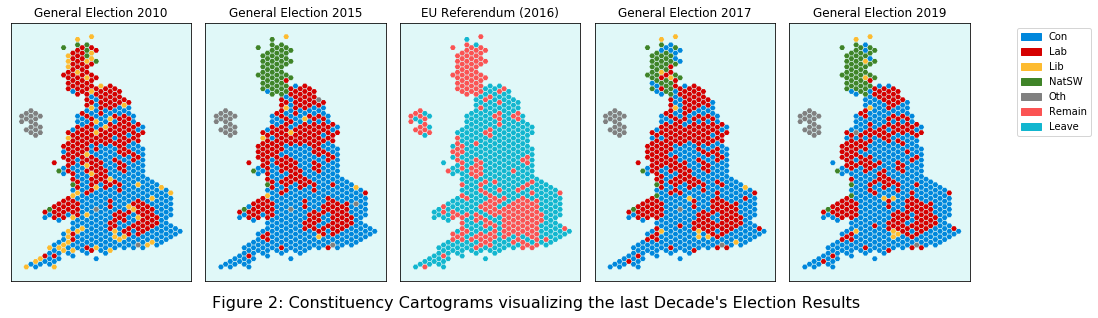

In [46]:
colours['leave'] = '#12b6cf'
colours['remain'] = '#fb5353'

parties = ['con','lab','lib','natSW','oth','leave','remain']

f, ax = plt.subplots(1,len(recent), figsize=(15,5))

for i,e in enumerate(recent):
    for p in parties:
        plot[e][p].plot(color = colours[p], ax=ax[i])
        ax[i].set_facecolor('#e0f8f8')
        ax[i].get_xaxis().set_ticks([])
        ax[i].get_yaxis().set_ticks([])
    if e == 'Brexit': e = 'EU Referendum (2016)'
    else: e = f'General Election {e}'
    ax[i].set_title(e)

patch = {}
for p in parties:
    patch[p] = mpatches.Patch(color=colours[p], label=p.capitalize().replace('sw','SW'))
    
plt.legend(handles=[patch['con'],
                    patch['lab'],
                    patch['lib'],
                    patch['natSW'],
                    patch['oth'],
                    patch['remain'],
                   patch['leave']],
           bbox_to_anchor=(1.7, 1)
                    )

f.suptitle('Figure 2: Constituency Cartograms visualizing the last Decade\'s Election Results',
            fontsize=16,
            y=0.1)
f.tight_layout()
plt.show()

We then map the last decade's election results (Fig.2 Constituency Cartograms). 

In the middle of the four General Elections, we have the 2016 Referendum on whether the UK should 'Leave' or 'Remain in' the European Union. This, in contrast to the normal pattern of British politics, was not a vote in which individual constituencies were 'won' by 'Leave' or 'Remain'; unlike parliamentary elections, all that mattered was the total vote count across the whole Kingdom. Indeed, the administrative boundaries in which votes were counted crossed constituency boundaries (except in some cases), and so it is only possible to estimate the counts within constituncies.

Nevertheless, it is illuminating to consider how individual constituencies probably voted at the referendum within the pattern across the decade. For the General Elections I have used colours that correspond to the official colours of the parties (though the SNP has had to share the green of the Welsh nationalists Plaid Cymru, as that is how the House of Commons Library had collated the 1918-2017 data; also it helps distinguish them from the Liberal Democrats). But for the EU Referendum I have deliberately chosen colours that make Leave look similar to the Conservatives (it is also the colour of the Brexit Party, but that was a secondary consideration, and strictly speaking the association is anachronistic), and Remain to Labour. 

This reflects the direction that the parties subsequently moved in, with Theresa May's 'Brexit means Brexit' and then Boris Johnson's 'Get Brexit Done!'; while Labour under Jeremy Corbyn eventually endorsed a second referendum ([Independent, 2019](https://www.independent.co.uk/news/uk/politics/general-election-brexit-second-referendum-corbyn-labour-boris-johnson-a9212381.html)).

In [47]:
dataset.set_index('id', inplace=True)
election2019.set_index('ons_id',inplace=True)

dataset.insert(loc=1,column='region',value=election2019['region_name'])
dataset.insert(loc=2,column='country',value=election2019['country_name'])
dataset.insert(loc=3,column='Electorate',value=election2019['electorate'])

In [48]:
recent.remove('Brexit')

In [49]:
for e in recent:
    df = election[e].set_index('constituency_id')
    dataset.insert(loc=4,column=f'Con%{e}',value=df.con_share)
    dataset.insert(loc=5,column=f'Lab%{e}',value=df.lab_share)
    dataset.insert(loc=6,column=f'GE{e}',value=df.winning_party)
    dataset.insert(loc=7,column=f'Turnout{e}', value=df.turnout*100)

In [50]:
df = election['Brexit'].set_index('constituency_id')
dataset.insert(loc=4,column=f'Leave%',value=df.leave_vote*100)
dataset.insert(loc=4,column=f'Remain%',value=(1-df.leave_vote)*100)
dataset.insert(loc=4,column=f'Brexit',value=df.winning_party)

### 1.2 Demographic Data

Various comments have been made about the demographic causes of the fall of Labour's Northern 'Red Wall' (eg. FT 2019, Goodwin 2019). If we are to join that discussion we need to find some relevant demographic data.

[Visualizing Your Contiuency by ONS (2015)](https://www.ons.gov.uk/peoplepopulationandcommunity/housing/articles/visualisingyourconstituency/2015-03-26) includes data for each constituency collated from various sources, on seven features of interest: Average House Price (only for England and Wales), Average Full-Time Salary, Public Sector Employment (not for Northern Ireland), % with Degree, Average Age, % Non-UK Born, and % with Good Health. 

In [51]:
seven_features = pd.read_csv('https://static.ons.gov.uk/visual/2015/03/UK-constituency-data.csv')
for col in ['house','salary','publicsector','degree','age','nonukborn','health']:
    seven_features[col] = pd.to_numeric(seven_features[col], errors='coerce')
    
df = seven_features.set_index('PCON14CD')
features = list(df.columns[1:])
for feature in features:
    if feature != 'age':
        dataset.insert(loc=3,column=feature.capitalize(),value=df[feature])

We can supplement this with selected data from various other sources:

- Religion data  from [the House of Common Library's (2020) Constituency Explorer](http://www.constituencyexplorer.org.uk/) (the statistics are based on the 2011 Census). I've chosen to include the percentages within a constituency of self-identified Non-Religious, Muslims, and Christians).

- Employment data from the Annual Population Survey available from [NOMIS (2020)](https://www.nomisweb.co.uk/reports/lmp/wpca/contents.aspx). Following the typology given by Browne (2010), I've included as 'Working Class' the aggregate percentage of skilled trades occupations, caring, leisure and other service occupations, sales and customer service occupations, and process, plant and machine operatives.

- More detailed and up-to-date Age data estimated by the Office of National Statistics ([ONS, 2019c](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/parliamentaryconstituencymidyearpopulationestimates)). The details of exactly how many people there are of each year-cohort are too precise for our purposes; I've called the under 30s 'Young', the over-60s 'Old', and those in-between 'Middle-Aged', and included the figure as a percentage of the total constituency population.

In [55]:
# religion data
# url = 'http://www.constituencyexplorer.org.uk/data/religion.zip'

# r = requests.get(url)
# r.content
# z = zipfile.ZipFile(io.BytesIO(r.content))
# religion_data = pd.read_csv(z.open('religion.csv'), encoding="ISO-8859-1")

df = religion_data.set_index('mnemonic')

dataset.insert(loc=3,column='Atheist%',value=df['No Religion (percent)'])
dataset.insert(loc=3,column='Muslim%',value=df['Muslim (percent)'])
dataset.insert(loc=3,column='Christian%',value=df['Religion of residents|Christian (percent)'])

KeyError: "None of ['mnemonic'] are in the columns"

In [ ]:
# employment data
# employment.csv obtained by querying the Annual Population Survey obtained from [NOMIS (2020)](https://www.nomisweb.co.uk/query/select/getdatasetbytheme.asp?theme=28)
employment = pd.read_csv(os.path.join('data','employment_type.csv'), header=6, skip_blank_lines=True).dropna()

df = employment.set_index('mnemonic')

for col in ['% all in employment who are - 5: skilled trades occupations (SOC2010)',\
           '% all in employment who are - 6: caring, leisure and other service occupations (SOC2010)',\
           '% all in employment who are - 7: sales and customer service occupations (SOC2010)',\
           '% all in employment who are - 8: process, plant and machine operatives (SOC2010)']:
    pd.to_numeric(df[col], errors='coerce')

df['working_class'] = pd.to_numeric(df['% all in employment who are - 5: skilled trades occupations (SOC2010)'], errors='coerce') \
+ pd.to_numeric(df['% all in employment who are - 6: caring, leisure and other service occupations (SOC2010)'], errors='coerce')\
+ pd.to_numeric(df['% all in employment who are - 7: sales and customer service occupations (SOC2010)'], errors='coerce')\
+ pd.to_numeric(df['% all in employment who are - 8: process, plant and machine operatives (SOC2010)'], errors='coerce')

dataset.insert(loc=3,column='WorkingClass%',value=df['working_class'])

In [ ]:
# detailed age data

# url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fparliamentaryconstituencymidyearpopulationestimates%2fmid2018sape21dt7/sape21dt7mid2018parliconsyoaestimatesunformatted.zip'
# pd.read_csv(url)
# # HTTPError: HTTP Error 403: Forbidden # so save and read from file

age_pyramid = pd.read_excel(os.path.join('data', 'SAPE21DT7-mid-2018-parlicon-syoa-estimates-unformatted.xlsx'), sheet_name=3, header = 4)

ages = ['Young','MiddleAged','Old']
age_pyramid['Total'] = 0
population = 0
for a in ages:
    age_pyramid[a] = 0
    
for age in range(0,90):
#     divide ages by thirty-year intervals
    divide = age//30
    age_pyramid[ages[divide]] = age_pyramid[age] + age_pyramid[ages[divide]]

age_pyramid.Old = age_pyramid.Old + age_pyramid['90+']

for a in ages:
    age_pyramid[f'{a}%'] = age_pyramid[a]/age_pyramid['All Ages']*100
    

In [ ]:
df = age_pyramid.set_index('PCON11CD')
dataset.insert(loc=3, column='Population', value=df['All Ages'].astype('int64'))
for a in ages:
    dataset.insert(loc=3,column=a,value=df[f'{a}%'])

In [ ]:
result = {}
for e in recent:

    result[e] = dataset.groupby('region')[f'GE{e}'].describe().top.apply(lambda x: x[0].capitalize()+x[1:]) \
    + '('\
    + dataset.groupby('region')[f'GE{e}'].describe().freq.astype('str') \
    + '/' + dataset.groupby('region')[f'GE{e}'].describe()['count'].astype('str')\
    + ')' #+ dataset.groupby('region')[f'Con%{e}'].mean().round(decimals=2).astype('str') \
#     + dataset.groupby('region')[f'Lab%{e}'].mean().round(decimals=2).astype('str')
    

In [ ]:
ordered = ['Con%2019','Lab%2019','Turnout2019','Leave%',
        'Population', 'Electorate', 'Old', 'MiddleAged', 'Young', 'Nonukborn', # population
          'Atheist%', 'Christian%', 'Muslim%', # religion
          'Salary','WorkingClass%', 'Publicsector', # work
          'House','Degree','Health'] # quality of life]
region = dataset.groupby('region').mean()[ordered].round(decimals=2)
r_df = {}
for r in recent:
    r_df[r] = pd.DataFrame(result[r], columns = [r])
for r in recent:
    region.insert(loc=0,column = r, value=r_df[r][r])

In [ ]:
display(HTML('<strong>Table 2: Electoral & Demographic Statistics for Constituencies grouped by Region</strong>'))
region.T.round(decimals=2)

## 2. Unsupervised Machine Learning: Clustering

In [ ]:
from sklearn.preprocessing import scale # normalize attribute vectors 
import sklearn.cluster as cluster # clustering methods
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score # cluster quality scores
from sklearn.decomposition import PCA # dimensionality reduction

In [ ]:
Image(os.path.join('images','machine_learning.png'),width=300, height=300)

By a 'cluster', we mean something like a set of datapoints that are close to each another, and far from points in other clusters. For our purposes we don't need to define the word any more rigorously; we just need to find a suitable algorithm that will help us separate our datasets into acceptable clusters.

Python's [scikit-learn library](https://scikit-learn.org/stable/modules/clustering.html#clustering) (Pedregosa et al. 2011) offers such several such algorithms, but as we shall see, each algorithm's different implementation of what 'close to each other, and far from others' should mean, leads to different clusters, and different degrees of success with different varieties.

It is possible to move the other way and reduce dimensionality: having conceptualized our dataset as a linear matrix of attribute vectors, *principal component analysis* or PCA (Wold et al, 1987), allows us to maximise the information-retaining variance in our attribute vectors. We will use this when we want to inspect our dataset visually.

Scikit-learn provides three ways of quanitfying cluster quality: the 'Calinski-Harabasz index' (the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion, Caliński & Harabasz, 1974), the 'Silhouette Coefficient' (Rousseeuw, 1987), and the Davies-Bouldin score (Davies & Bouldin, 1979). Simplistically, higher is better for the first two, lower for the third.

We will try all the scikit-learn algorithms on our data, and see whether any significant differences emerge. But first we will scale our data, so that each attribute vector is centred to the mean with unit variance, and looks more or less like a statistically *normal* Gaussian distribution. We also need to make sure the data is all non-null and numeric.

We will deliberately exclude political characteristics from our clustering analysis so that we can see whether the divisions of the political map reflect demographic characteristics or not.

In [ ]:
np.random.seed(1987) # set random seed for reproducibility

In [ ]:
of_interest = [ #'Con%2019', 'Lab%2019', 'Leave%', # political
               'Nonukborn', # immigration
               'Muslim%','Atheist%','Christian%', #religion
               'Old', 'MiddleAged', 'Young', # age
               'WorkingClass%', 'Salary', 'Publicsector', 'House', # affluence
               'Degree', #education
               'Health']  #health

In [ ]:
scaled_values = scale(dataset[of_interest]) # subtract mean and divide by variance to scale

scaled_data = pd.DataFrame(scaled_values, 
                 columns = of_interest,
                index=dataset.index
                )

In [ ]:
filled_scaled_data = scaled_data.fillna(value=0) # since we have scaled so that the mean is now zero, replacing na values with zero is equivalent to replacing them with the mean

In [ ]:
clustering_algorithms = ['KMeans', 'AffinityPropagation','MeanShift', 'SpectralClustering', 'AgglomerativeClustering','DBSCAN', 'OPTICS', 'Birch']
n_clusters = 5
estimator = {}
labels = {}
calinski = {}
silhouette = {}
davies = {}

for algorithm in clustering_algorithms:
    
    method_to_call = getattr(cluster, algorithm)
    try:
            estimator[algorithm] = method_to_call(n_clusters=n_clusters)
    except:
        estimator[algorithm] = method_to_call()
    estimator[algorithm].fit(filled_scaled_data)
    labels[algorithm]  = pd.DataFrame(estimator[algorithm].labels_, index=dataset.index) 
    try:
        calinski[algorithm] = calinski_harabasz_score(filled_scaled_data, labels[algorithm])
    except:
        print(f'Could not compute Calinski-Harabasz score for {algorithm}')
        calinski[algorithm] = 'Could not compute'
    try:
        silhouette[algorithm] = silhouette_score(filled_scaled_data, labels[algorithm])
    except:
        print(f'Could not compute Silhouette score for {algorithm}')
        silhouette[algorithm] = 'Could not compute'
    try:
        davies[algorithm] = davies_bouldin_score(filled_scaled_data, labels[algorithm])
    except:
        print(f'Could not compute Davies-Bouldin score for {algorithm}')
        davies[algorithm] = 'Could not compute'


In [ ]:
pca_estimator = PCA(n_components=2)
component_values = pca_estimator.fit_transform(filled_scaled_data)
components = pd.DataFrame(component_values,
                              index = dataset.index,
                              columns = ["PCA-1", "PCA-2"]
                             )

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(18, 10))

for n, algorithm in enumerate(clustering_algorithms):
    
    i = n // 4
    j = n % 4

    components.assign(labels=labels[algorithm])\
          .plot.scatter("PCA-1", 
                        "PCA-2",
                        c='labels',
                        s=16,
                        cmap="Dark2",
                        colorbar=False,
                        ax=axs[i,j]
                       )
    n_clusters = len(pd.Series(estimator[algorithm].labels_).unique())
    title = f'{algorithm}: {str(n_clusters)} cluster' 
    if n_clusters > 1:
        title = title + 's'
    title = f'{title}\nC-H: {calinski[algorithm]}\nSil.: {silhouette[algorithm]}\nDavies: {davies[algorithm]}'
    axs[i,j].set_title(title, loc='left', y=0.75, x=0.1)

f.suptitle('Figure 3: Cluster Analysis for Different Algorithms',
            fontsize=16,
            y=-0.0)
f.tight_layout()    

plt.show()

scores = pd.DataFrame({'Calinski-Harabasz':pd.Series(calinski),'Silhouette':pd.Series(silhouette),'Davies-Bouldin':pd.Series(davies)})
scores
pass

The K-Means Algorithm gives us the highest Calinski-Harabasz index, the third-highest Silhouette score, and the third-lowest Davies-Bouldin score. Visual inspection of the clusters projected into two-dimensions allows us also to see that K-Means has managed more evenly numbered clusters than either of the two with higher Silhouette scores.

We will therefore now investigate what the K-Means cluster typologies might tell us about the demographies and geographies of the different types of UK political constituencies.

In [ ]:
hexagons.set_index('constituency_id', inplace=True)

In [ ]:
filled_scaled_data.insert(loc=0,column='Cluster',value=labels['KMeans'][0])
hexagons.insert(loc=0, column='Cluster', value=filled_scaled_data['Cluster'])

In [ ]:
politics = ['Leave%','Con%2019','Lab%2019','Con%2010','Lab%2010','Turnout2010','Turnout2019']

In [ ]:
scaled_politics = scale(dataset[politics]) # subtract mean and divide by variance to scale

scaled_pol_df = pd.DataFrame(scaled_politics, 
                 columns = politics,
                index=dataset.index
                )

In [ ]:
filled_scaled_data.insert(loc=0,column="Turnout '10",value=scaled_pol_df['Turnout2010'])
filled_scaled_data.insert(loc=0,column="Labour '10",value=scaled_pol_df['Lab%2010'])
filled_scaled_data.insert(loc=0,column="Conservative '10",value=scaled_pol_df['Con%2010'])
filled_scaled_data.insert(loc=0,column='Voted Leave',value=scaled_pol_df['Leave%'])
filled_scaled_data.insert(loc=0,column="Turnout '19",value=scaled_pol_df['Turnout2019'])
filled_scaled_data.insert(loc=0,column="Labour '19",value=scaled_pol_df['Lab%2019'])
filled_scaled_data.insert(loc=0,column="Conservative '19",value=scaled_pol_df['Con%2019'])


In [ ]:
f, axs = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 3]})

clusters = range(0,5)


hex_clusters = {}
for c in clusters:
    hex_clusters[c] = hexagons[hexagons['Cluster']==c]

# colours chosen with the help of https://coolors.co/536648-577399-bdd5ea-f7f79e-fe5f55
cluster_colors = ['#BDD5EA', '#536648', '#577399', '#FE5F55', '#F7F79E']

ax = axs[0]

for c in clusters:
    hex_clusters[c].plot(color=cluster_colors[c], ax=ax)
    ax.set_facecolor('#e0f8f8')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
ax.set_title('Geographical Distribution')

c_patch = {}
handles = []
c_counts = filled_scaled_data['Cluster'].value_counts()
named_clusters = ['Old Working-Class',
                 'Secular Public-Servants',
                 'Tory Heartlands',
                 'Core Labour',
                 'Metropolitan Remainers']
for c in clusters:
    c_patch[c] = mpatches.Patch(color=cluster_colors[c], label=f'{c}.{named_clusters[c]} ({c_counts[c]})')
    handles.append(c_patch[c])
    
plt.legend(handles=handles, bbox_to_anchor=(-0.05, 0.95), labelspacing=5.5, frameon=False)


sns.heatmap(filled_scaled_data.groupby('Cluster').mean(), annot=True, ax=axs[1], cmap="RdYlBu")
axs[1].set_title('Demographic Characteristics')


f.suptitle('Figure 4: Visualizing Cluster Results\nGeo- & Demo-Graphically',
            fontsize=16,
            y=0.15, x = 0.17)
f.tight_layout()
plt.show()

We now have a Geo-/Demo-*Graphic* analysis of the constituencies of the UK. I have deliberately coloured it to suggest what I perceive as the similarities with the political maps already shown.

Cluster **0** we might call the *Old Working Class*. It is the largest grouping, including 276 constituencies. Demographically, it has the least immigrants (here defined as non-UK-born); the most who still identify as Christians; the most elderly; the most working-class; the lowest house values; the least graduates; and the worst health. It had the highest vote to leave the EU, and it is no longer voting Labour.

Cluster **1**, we will call the *Secular Public-Servants*. They have a large proportion of workers for the public sector, and the highest proportion of atheists. They vote less than average for either the Conservatives or Labour.

Cluster **2**, the *Tory Heartlands*, is second-largest, with 186 constituencies. It also has less immigrants, and the least Muslim percentage. It is the most politically engaged in terms of turnout, the most likely to vote Conservative and the least to vote Labour. It has the lowest proportion employed by the state, and the lowest proportion of under-30s.

Cluster **3** appears to now be the *Core Labour* vote, but is also the most politically disengaged in terms of turnout. It has high numbers of immigrants, though not the highest; the highest number of Muslims, and the lowest number of Christians and of Atheists; and the highest number of young people.

Cluster **4** consists of *Metropolitan Remainers*. These were least likely to vote Leave, and that is surely linked to the fall in their support for the Conservatives between 2010 and 2019, and also a noticeable increase in political engagement. These are most likely to be in the midst of their working life, with the highest salaries, and the most education.

## 3. Supervised Machine Learning: Linear Regression

In [ ]:
Image(os.path.join('images','stats-ml-ai.png'),width=300, height=300)

For our final task, we will use the `mlxtend` package's `Exhaustive Feature Selector` (Raschka, 2018) to find the best linear regression models for the Conservatives 2019 General Election vote share in each constituency, using one, two, three, four and five variables -- and only those that predate the 2019 results. 

We run the Exhaustive Feature Selector first without using its cross-validation functionality, and then again using it, and we time each loop seven times each, so that we can compare the mean and variance, and consider whether the improvement in confidence we can justifiably have in the performance score of our models is worth the extra processing-time cost.

In [ ]:
# https://www.r-bloggers.com/practical-machine-learning-with-r-and-python-part-3/
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS # http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/

In [ ]:
cols = list(filled_scaled_data.columns)

In [ ]:
remove = ['Cluster',"Conservative '19", "Labour '19", "Turnout '19"]

In [ ]:
for col in remove:
    cols.remove(col)

In [ ]:
df = filled_scaled_data[cols].fillna(value=0)

In [ ]:
X, y = df, filled_scaled_data["Conservative '19"]

In [ ]:
lr = LinearRegression()
efs = {}
efs_no_cv = {}
best = {}
best_no_cv = {}
time = {}
time_no_cv = {}

In [ ]:
for i in range(1,6):
    efs_no_cv[i] = EFS(lr, 
           min_features=1,
           max_features=i,
           scoring='neg_mean_squared_error',
           print_progress=False,
           cv=0)

#     time_no_cv[i] = %timeit -o efs_no_cv[i].fit(X,y,custom_feature_names=cols)
    efs_no_cv[i].fit(X,y,custom_feature_names=cols)
    best_no_cv[i] = efs_no_cv[i].best_feature_names_
#    print('Best subset (corresponding names):', best_no_cv[i])

In [ ]:
for i in range(1,6):
    efs[i] = EFS(lr, 
           min_features=1,
           max_features=i,
           scoring='neg_mean_squared_error',
           print_progress=False,
           cv=5)

#     time[i] = %timeit -o efs[i].fit(X,y,custom_feature_names=cols)
    efs[i].fit(X,y,custom_feature_names=cols)
    best[i] = efs[i].best_feature_names_
#    print('Best subset (corresponding names):', best_no_cv[i])

In [ ]:
# time_df = pd.DataFrame(time, index=time)
# time_no_cv_df = pd.DataFrame(time_no_cv, index=time_no_cv)
# time_df.to_csv(os.path.join('data','t-df.csv'))
# time_no_cv_df.to_csv(os.path.join('data','t_no_cv-df.csv'))
t_df = pd.read_csv(os.path.join('data','t-df.csv'),index_col = 0)
t_no_cv_df = pd.read_csv(os.path.join('data','t_no_cv-df.csv'), index_col = 0)

In [ ]:
formula = {}
for i in range(1,6):
    sum = ''
    for j, predictor in enumerate(best[i]):
        if j == 0:
            sum = f'Q("{predictor}")'
        else:
            sum = f'{sum} + Q("{predictor}")'

    formula[i] = f'Q("Conservative \'19") ~ {sum} '
    

In [ ]:
lm = {}
lm_df = {}
coefs = {}
for i in range(1,6):
    
    lm[i] = sm.ols(formula[i], filled_scaled_data)\
       .fit()
    lm_df[i] = pd.DataFrame(lm[i].summary().tables[1])[:][[0,1]]
    coefs[i] = lm_df[i].set_index(0)

In [ ]:
table = []
for i in range(1,6):
    table.append({i: coefs[i]})

In [ ]:
r_squared = {}
for i in range(1,6):
    r_squared[i] = lm[i].rsquared

In [ ]:
table = pd.DataFrame({
        1: lm[1].params,
        2: lm[2].params,
        3: lm[3].params,
        4: lm[4].params,
        5: lm[5].params
    })

In [ ]:
r_squared = pd.DataFrame(r_squared, index=r_squared)

In [ ]:
cv_score = {}
for i in range(1,6):
    cv_score[i] = efs[i].best_score_

In [ ]:
no_cv_score = {}
for i in range(1,6):
    no_cv_score[i] = efs_no_cv[i].best_score_

In [ ]:
no_cv_score = pd.DataFrame(no_cv_score, index=no_cv_score)

In [ ]:
cv_score = pd.DataFrame(cv_score, index = cv_score)

In [ ]:
table = table.T
# table.insert(loc=8,column = 'R-Squared',value=r_squared.T[1])

In [ ]:
# table.insert(loc=9,column = 'Cross-Validation',value=cv_score.T[1])

In [ ]:
# table.insert(loc=10,column = 'Score w/o C-V',value=no_cv_score.T[1])

In [ ]:
# table.insert(loc=11, column = '$t_{CV}$', value=time_df.T[1])

In [ ]:
# table.insert(loc=11, column = '$t_{0}$', value=time_no_cv_df.T[1])

In [ ]:
# table.to_csv(os.path.join('data','5lm.csv'))

In [ ]:
table = pd.read_csv(os.path.join('data','5lm.csv'), index_col = 0)

In [ ]:
display(HTML('<strong>Table 3: Best Five Linear Regression Models with R-Squared and Cross-Validation Scores, plus timing with and without C-V</strong>'))
table.round(decimals=2).fillna(value='-')

Although we have talked in terms of a shift in the political geography of the United Kingdom, it turns out that the one variable that best predicted the Conservatives 2019 General Election vote percentage in each constituency was in fact their share of the vote in the 2010 Election. Unsurprisingly, the one that joins that in the two-variable linear model is the (estimated) percentage that Voted Leave. Beyond those two, extra variables only add slightly to the model-fit (increasing R-squared by no more than two percentage points, from an already high score of 86% for the two variables) -- or indeed, sometimes take away from it (when moving from four to five models). This can also be seen in Figure 5, where we have plotted kernel density plots for each of our five linear models. 

Nor does our analysis suggest any clarity about which might be the third most significant predictor -- the Turnout in 2010 is included in the three-variable model, then replaced by Health and the percentage of Old people for the four-variable model, then returns in the five-variable model to join Atheism and Higher Education.

Timing the cross-validation shows that it adds almost ten-fold to the running time for five-fold cross-validation. In this case it only seems to make a small difference to the performance score, but of course we can only find that out by doing it.

In [ ]:
f, ax = plt.subplots(2, 3, figsize=(20, 12))
sns.kdeplot(filled_scaled_data["Conservative '19"], shade=True, ax=ax[0,0], label='$y$')
ax[0,0].set_ylim(top=0.5)

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for k in range(1,6):
    i = k // 3
    j = k % 3
    sns.kdeplot(filled_scaled_data["Conservative '19"], shade=True, ax=ax[i,j], label='$y$')
    sns.kdeplot(lm[k].fittedvalues, shade=True, c=flatui[k], ax=ax[i,j], label='$\hat{y}_'+str(k)+'$')
    ax[i,j].set_ylim(top=0.5)

f.suptitle('Figure 5: Assessing Linear Regresssion Model Fit for Five Models of Increasing Complexity',
            fontsize=16,
            y=-0.0)
f.tight_layout()    
    
plt.show()

## 5. References

Abraham, L. (2009). ‘Effectiveness of Cartoons as a Uniquely Visual Medium for Orienting Social Issues’. Journalism & Communication Monographs 11, no. 2 (1 June 2009): 117–65. https://doi.org/10.1177/152263790901100202.

Arribas-Bel, D. (2014). ‘Accidental, Open and Everywhere: Emerging Data Sources for the Understanding of Cities’. Applied Geography, The New Urban World, 49 (1 May 2014): 45–53. https://doi.org/10.1016/j.apgeog.2013.09.012.

Bilogur, Karve, Marsano, and Fleischmann (2019). ResidentMario/Geoplot 0.3.3. Zenodo. https://doi.org/10.5281/zenodo.3475569.

Browne, K. (2011). An Introduction to Sociology. Polity.

Caliński, T., & Harabasz, J. (1974). “A Dendrite Method for Cluster Analysis”. Communications in Statistics-theory and Methods 3: 1-27. doi:10.1080/03610927408827101.

Cummings, D. (2017). *‘Unrecognised Simplicities of Effective Action #1: Expertise and a Quadrillion Dollar Business’*. Dominic Cummings’s Blog, 13 January 2017. https://dominiccummings.com/2017/01/13/unrecognised-simplicities-of-effective-action-1-expertise-and-a-quadrillion-dollar-business/.

Cummings, D. (2020). *“Two Hands Are a Lot” — We’re Hiring Data Scientists, Project Managers, Policy Experts, Assorted Weirdos…* Dominic Cummings’s Blog, 2 January 2020. https://dominiccummings.com/2020/01/02/two-hands-are-a-lot-were-hiring-data-scientists-project-managers-policy-experts-assorted-weirdos/.

Davenport and Patil. (2012). ‘Data Scientist: The Sexiest Job of the 21st Century’. Harvard Business Review, 1 October 2012. https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century.

Davies, David L.; Bouldin, Donald W. (1979). “A Cluster Separation Measure” IEEE Transactions on Pattern Analysis and Machine Intelligence. PAMI-1 (2): 224-227. doi:10.1109/TPAMI.1979.4766909.

Deisenroth, Faisal, and Ong (2020). Mathematics for Machine Learning. Cambridge ; New York, NY: Cambridge University Press.

Dempsey, N. (2017). ‘Brexit: Votes by Constituency’. https://commonslibrary.parliament.uk/parliament-and-elections/elections-elections/brexit-votes-by-constituency/.

Donoho, D. (2017). ‘50 Years of Data Science: Journal of Computational and Graphical Statistics: Vol 26, No 4’. https://www.tandfonline.com/doi/full/10.1080/10618600.2017.1384734.

FT: Financial Times (2019). ‘How Class, Turnout and the Brexit Party Shaped the General Election Result | Financial Times’. Accessed 27 February 2020. https://www.ft.com/content/bc09b70a-1d7e-11ea-97df-cc63de1d73f4.

Flanagan, B. (2017). GB Parliamentary Constituency Hexagon Cartogram (Esri Shapefile). ESRI. https://www.arcgis.com/home/item.html?id=15baaa6fecd54aa4b7250780b6534682

Geopandas Development Team (2020). Geopandas/Geopandas: V0.7.0. Zenodo, https://doi.org/10.5281/zenodo.3669853.

Goodwin, M. (2019). ‘Nine Lessons from the Election: Boris Was Lucky – but He Also Played His Hand Right’. https://blogs.spectator.co.uk/2019/12/nine-lessons-from-the-election-boris-was-lucky-but-he-also-played-his-hand-right/.

Harris, R., Sleight, P., and Webber, R. (2005). Geodemographics, GIS and Neighbourhood Targeting. Mastering GIS. West Sussex, England ; Hoboken, N.J: Wiley.

House of Commons Library (2020). [Constituency Explorer](http://www.constituencyexplorer.org.uk/credits).

Hunter, J. D. (2007). ‘Matplotlib: A 2D Graphics Environment’. Computing in Science Engineering 9, no. 3, May 2007: 90–95. https://doi.org/10.1109/MCSE.2007.55.

Kitchin, R. (2014). The Data Revolution. Sage.

Loft, P., Uberoi, E., and Hicks, E. (2019). ‘General Election Results from 1918 to 2017’, 19 August 2019. https://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-8647.

McKinney, W. (2010). [‘Data Structures for Statistical Computing in Python’](https://pdfs.semanticscholar.org/f6da/c1c52d3b07c993fe52513b8964f86e8fe381.pdf). In Proceedings of the 9th Python in Science Conference, 445:51–56. Austin, TX.

McKinney, W. (2011). Python for Data Analysis. O'Reilly.

Oliphant, T.E. (2006). Guide to NumPy. Austin, Tex.

ONS: Office for National Statistics (2015). ‘Visualising Your Constituency’. Accessed 5 March 2020. https://www.ons.gov.uk/peoplepopulationandcommunity/housing/articles/visualisingyourconstituency/2015-03-26.

ONS: Open Geography Portal (2019). Westminster Parliamentary Constituencies (December 2017) Generalised Clipped Boundaries in the UK. http://geoportal.statistics.gov.uk/datasets/5ce27b980ffb43c39b012c2ebeab92c0_2

ONS: Office for National Statistics (2019b). Population density by constituency for 2015. Freedom of Information Request. https://www.ons.gov.uk/aboutus/transparencyandgovernance/freedomofinformationfoi/populationdensitybyconstituencyfor2015

ONS: Office for National Statistics (2019c). [‘Parliamentary Constituency Population Estimates (Experimental Statistics)](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/parliamentaryconstituencymidyearpopulationestimates).

Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python, JMLR 12, pp. 2825-2830.

Raschka, Sebastian (2018). MLxtend: Providing machine learning and data science utilities and extensions to Python's scientific computing stack.
J Open Source Softw 3(24).

Rousseeuw, P.J. (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”. Computational and Applied Mathematics 20: 53-65.

Sleight, P. (1997) ‘Targeting customers — How to use geodemographic and lifestyle data in your business’, 3rd edn, WARC (for propensity modelling).

Spielman, S. and Folch, D. (2015). Chapter 9: Social Area Analysis and Self-Organizing Maps. In: Geocomputation: A Practical Primer. SAGE.

Tukey, J. (1962). ‘The Future of Data Analysis’. The Annals of Mathematical Statistics 33, no. 1 (March 1962): 1–67. https://doi.org/10.1214/aoms/1177704711.

Uberoi, E., Baker, C., and Cracknell, R (2020). ‘General Election 2019: Full Results and Analysis’. House of Commons Library. https://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-8749.

Van Rossum, G., and Drake Jr., F. (1995). Python Reference Manual. Centrum voor Wiskunde en Informatica Amsterdam.

Walt, Stéfan van der (2019). ‘Scientific Python: A Mature Computational Ecosystem for Microscopy’. Microscopy and Microanalysis 25, no. S2 (August 2019): 132–33. https://doi.org/10.1017/S1431927619001399.

Webber, R., and Burrows, R. (2018). The Predictive Postcode: The Geodemographic Classification of British Society. Los Angeles: SAGE.

Wikipedia (2019). ‘Representation of the People Act 1948’. In Wikipedia, 9 June 2019. https://en.wikipedia.org/w/index.php?title=Representation_of_the_People_Act_1948&oldid=901008136.

Wikipedia (2020). List of British Governments. https://en.wikipedia.org/wiki/List_of_British_governments

Wold, S., Esbensen, K., and Geladi, P. (1987). ‘Principal Component Analysis’. Chemometrics and Intelligent Laboratory Systems 2, no. 1–3 (1987): 37–52.

Woodcock (2019). 'General election: Final Say referendum will be legally-binding, says Corbyn'. Independent. https://www.independent.co.uk/news/uk/politics/general-election-brexit-second-referendum-corbyn-labour-boris-johnson-a9212381.html